In [1]:
!pip install cvxopt

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable
  Using cached cvxopt-1.2.7.tar.gz (4.1 MB)
anceled
ERROR: Operation cancelled by user


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg

In [3]:
r0 = np.random.randint(-100,100,3)
r1 = np.random.randint(-100,100,3)
r2 = np.random.randint(-100,100,3)
r3 = np.random.randint(-100,100,3)

g = np.random.randint(-100,100,3)

print(np.cross(  r0 + r1 + r2 + r3, g  ))

print(np.cross( r0, g  ) + np.cross( r1, g  ) + np.cross( r2, g  ) + np.cross( r3, g  ))

[-10260  -1062    798]
[-10260  -1062    798]


CatBot Lab Context: This notebook supports the CatBot course and focuses on Predictive model control.

# Predictive model control

000

In [ ]:
I_ = np.array([[1,   0.1, 0.1],        # inertia matrix
              [0.1, 1,   0.1],
              [0.1, 0.1,   1]])


m = 2 # mass


def getRz(yaw):
    Rz = np.array([[np.cos(yaw),  np.sin(yaw), 0 ],
                   [-np.sin(yaw), np.cos(yaw), 0],
                   [0           , 0          , 1]])

    return Rz



def getAmatrix(yaw):
    Rz = getRz(yaw)
    O3 = np.zeros([3,3])
    I3 = np.eye(3)

    O3H = np.array([0,0,0])
    O3V = np.array([[0,0,0]]).T
    
    G3V = np.array([[0,0,-1]]).T

    A = np.vstack([  np.hstack( [O3,  O3,  Rz.T, O3, O3V]),
                     np.hstack( [O3,  O3,  O3,   I3, O3V]), 
                     np.hstack( [O3,  O3,  O3,   O3, O3V]),
                     np.hstack( [O3,  O3,  O3,   O3, G3V]),
                     np.hstack( [O3H, O3H, O3H, O3H, 0])])
    return A


def getCrossProduct(r):
    rx = np.array([[0,   -r[2],  r[1]],        # cross product
                  [r[2],  0,    -r[0]],
                  [-r[1], r[0],   0]])
    return rx

def getBmatrix(yaw, r0, r1, r2, r3):
    Rz = getRz(yaw)
    
    It_ = Rz.dot(I_).dot(Rz.T)
    It_inv = np.linalg.inv(It_)
    
    r0x = getCrossProduct(r0)
    r1x = getCrossProduct(r1)
    r2x = getCrossProduct(r2)
    r3x = getCrossProduct(r3)

    
    O3 = np.zeros([3,3])
    O3H = np.array([0,0,0])
    O3V = np.array([[0,0,0]]).T
    
    Idivm = np.eye(3)/m
        
    B = np.vstack([  np.hstack( [O3,  O3, O3, O3]), 
                     np.hstack( [O3,  O3, O3, O3]),
                     np.hstack( [It_inv.dot(r0x), It_inv.dot(r1x), It_inv.dot(r2x), It_inv.dot(r3x) ]),
                     np.hstack( [Idivm, Idivm, Idivm, Idivm] ),
                     np.hstack( [O3H, O3H, O3H, O3H] )
                  ])
    
    return B
    
A = getAmatrix(0)
print(A)
#B = getBmatrix(0, [1,1,0], [1,-1,0], [-1,1,0], [-1,-1,0])
B = getBmatrix(0, [0,0,0], [0,0,0], [0,0,0], [0,0,0])

print(B)

x0 = np.zeros(13)
x0[12] = 9.8           # GRAVITY ALWAYS POSITIVE



print(A.dot(x0))

In [ ]:
print(A.shape, B.shape)

We can predict the next state as:

\begin{equation}
x(t+1) = x(t) + \frac{dx(t)}{dt}\Delta t = x(t) + A\Delta t x(t) + B(t)\Delta tu(t) = (I^{13\times13} + A\Delta t)x(t) + B(t)\Delta tu(t)
\end{equation}

So we define the system:

\begin{equation}
x(t+1) = \hat{A}x(t) + \hat{B(t)}u(t)
\end{equation}

where

\begin{equation}
\hat{A} = I^{13\times13} + A\Delta t \quad \text{and} \quad \hat{B}(t) = B(t)\Delta t
\end{equation}

In [ ]:
linalg.expm(np.zeros([3,3]))

In [ ]:
def getADynMatrix(yaw, dt):
    A = getAmatrix(yaw)
    
    #A_dyn = np.eye(13) + A*dt
    A_dyn = linalg.expm(A*dt)
    return A_dyn

def getBdynMatrix(yaw, r0, r1, r2, r3, dt):
    A = getAmatrix(yaw)
    B = getBmatrix(yaw, r0, r1, r2, r3)
    A_dyn = linalg.expm(A*dt)
    print(A)
    return (np.linalg.inv(A) + dt*np.eye(len(A))).dot(B)
    #return B*dt

    
    
def getAandBdynMatrices(yaw, dt, r0, r1, r2, r3):
    A = getAmatrix(yaw)
    B = getBmatrix(yaw, r0, r1, r2, r3)
    
    A_ext_1 = np.hstack([A*dt, B*dt])
        
    A_ext_2 = np.hstack([np.zeros([12,13]), np.zeros([12,12])])
    
    A_ext = np.vstack([A_ext_1, A_ext_2])
    
    
    eA_ext = linalg.expm(A_ext)
    
    
    
    Adyn = eA_ext[:13, :13]
    Bdyn = eA_ext[:13, 13:13+12]
    return Adyn, Bdyn
    
    
dt = 0.1
#A_dyn = getADynMatrix(0, dt)
#Bdyn = getBdynMatrix(0, [0,0,0], [0,0,0], [0,0,0], [0,0,0], dt)

A_dyn, Bdyn = getAandBdynMatrices(0, dt, [0,0,0], [0,0,0], [0,0,0], [0,0,0])


u = np.zeros(12)
u[5] = 0#9.8*m

### Example of free fall
x = [x0]
print(x0)
for t in range(20):
    x.append(A_dyn.dot(x[-1]) + Bdyn.dot(u))


x = np.array(x)
plt.plot(x[:,5])
#plt.plot(x[:,12])


time = np.arange(0,20*dt,dt)
y_fall = 0 - 0.5*9.8*np.power(time,2)

plt.plot(y_fall)

print(Bdyn.shape)

Now we can can minimize:

\begin{equation}
min_{\mathbf{u}} \quad \sum_t^{k-1} \alpha||x(t+1) - x^{ref}(t+1)|| + \beta ||\mathbf{u}_i|| \\ \text{subject to} \begin{cases}
x(t+1) = \hat{A}x(t) \hat{B}(t) u(t)  \\
D_{min} \leq C\mathbf{u}_i \leq D_{max}  \quad\quad\quad\quad \text{for} \quad i =0,..., k-1\\
D_{i}\mathbf{u}_i= 0 
\end{cases}
\end{equation}

The matrices $D_{min}$ and $D_{max}$ ensure that the forces are within the piramid friccion, and $D_{i}$ is a matrix which selects forces corresponding with feet not in contact with the ground at timestep $i$.


We can write this in matrix notation for QP problem:

\begin{equation}
min_{\mathbf{u}} ||A_{qp}x(0) + B_{qp} - X_{ref}|| \\ \text{subject to} \begin{cases}
D_{min} \leq C\mathbf{u}_i \leq D_{max} \\
D_{i}\mathbf{u}_i= 0 
\end{cases}
\end{equation}

where $A_{qp}$ and $B_{qp}$ can be extracted from the fact that

\begin{equation}
\begin{cases}
x[1] = \hat{A}x(0) + \hat{B(0)}u(0) \\
x[2] = \hat{A}x(1) + \hat{B(1)}u(1) = \hat{A}^2x(0) + \hat{A}\hat{B}(0)u(0) + \hat{B}(1)u(1) \\
... \\
x[k] = \hat{A}^k x(0) + \sum_{i=0}^{k-1} \hat{A}^{i}B(k-i-1)u(k-i-1)
\end{cases}
\end{equation}

Then:

\begin{equation}
A_{qp} = 
\begin{pmatrix}
\hat{A} \\
\hat{A}^2 \\
... \\
\hat{A}^k
\end{pmatrix}
\end{equation}

and 

\begin{equation}
B_{qp} = 
\begin{pmatrix}
\hat{B}(0) & 0 & 0 & ...& 0 \\
\hat{A}\hat{B}(0) & \hat{B}(1) & 0 & ...& 0 \\
\hat{A}^2\hat{B}(0) & \hat{A}\hat{B}(1) & \hat{B}(2) & ...& 0 \\
... & ... & ... & ...& ... \\
\hat{A}^{k-1}\hat{B}(0) & \hat{A}^{k-2}\hat{B}(1) & \hat{A}^{k-3}\hat{B}(2) & ...& \hat{B}(k) \\
\end{pmatrix}
\end{equation}


In [ ]:
horizont_k = 4
Aqp = ['_']*horizont_k
Bqp = []
for k in range(horizont_k):
    Bqp.append([])
    for j in range(horizont_k):
        Bqp[k].append('_')


for k in range(horizont_k):

    Aqp[k] = 'A'*(k+1)

    
for k in range(horizont_k):
    for j in range(horizont_k):
        Bqp[j][k] = '0'
        if j == k:
            Bqp[j][k] = 'B({:d})'.format(k)
        if j > k:
            Bqp[j][k] =  'A'*(j-k) + 'B({:d})'.format(k)

            
            
            
            
print(Aqp)

for j in range(horizont_k):
    msg = ''
    for k in range(horizont_k):
        msg += Bqp[j][k] + '        '
        
        
    print(msg)

In [ ]:
def getAqpMatrix(horizont_k, yaw, dt):
    Adyn = getADynMatrix(yaw, dt)
    
    A_qp = np.zeros([13*horizont_k, 13] )
    
    for i in range(1, horizont_k+1):
        A_qp_power =  np.linalg.matrix_power(Adyn, i)
        A_qp[(i-1)*13:i*13] = A_qp_power
        
    return A_qp

def getBqpMatrix(horizont_k, yaw, r0_t, r1_t, r2_t, r3_t, dt):
    Adyn = getADynMatrix(yaw, dt)
    
    B_qp = np.zeros([13 * horizont_k, 12 * horizont_k])
    O12 = np.zeros([13,12])
        
    for col in range(horizont_k):
        B_col = getBdynMatrix(yaw, r0_t[col], r1_t[col], r2_t[col], r3_t[col], dt)
        for row in range(horizont_k):
            if col <= row:
                B_qp[13*row:13*(row+1), 12*col:12*(col+1)] = np.linalg.matrix_power(Adyn, row - col).dot(B_col)


            
    return B_qp  

    
horizont_k = 100
dt = 0.01
yaw = 0
r0t = np.zeros([horizont_k, 3])
r1t = np.zeros([horizont_k, 3])
r2t = np.zeros([horizont_k, 3])
r3t = np.zeros([horizont_k, 3])


Aqp = getAqpMatrix(horizont_k, yaw,  dt)
display(pd.DataFrame(Aqp))

Bqp = getBqpMatrix(horizont_k, yaw, r0t, r1t, r2t, r3t, dt)
display(pd.DataFrame(Bqp))

In [ ]:
x0 = np.zeros(13)
x0[12] = 9.8
u = np.zeros([horizont_k, 12])
u[:,2] = 9.8*m

U = np.reshape(u, horizont_k * 12 )
plt.figure()
plt.plot(U)

X = Aqp.dot(x0) + Bqp.dot(U) 

x_times = np.reshape(X, [horizont_k, 13])

plt.figure()
plt.plot(x_times[:,5])
plt.ylim([-0.1,0.1])

# Predictive Model Control for position

We start with the dynamical model:

\begin{equation}
\begin{cases}
m\mathbf{\ddot{p}} = \sum_i^n \mathbf{f}_i + m\mathbf{g} \\
I\dot{\omega} = \sum_i^n \mathbf{r_i}\times \mathbf{f_i}
\end{cases}
\end{equation}


Now we make the following approximations:
   - 1) The weight is distributed equally along the legs that are on the ground
   - 2) The normal of the ground is parallel to the gravity vector

We can define a vector $\mathbf{d_i}$ as the difference between the normal and the force:
\begin{equation}
\mathbf{d_i} = \mathbf{N_i} - \mathbf{f_i}
\end{equation}






then the dynamical system can be writen as:

\begin{equation}
\begin{cases}
m\mathbf{\ddot{p}} = \sum_i^n (\mathbf{N}_i - \mathbf{d}_i) + m\mathbf{g} \\
I\dot{\omega} = \sum_i^n \mathbf{r_i}\times (\mathbf{N}_i - \mathbf{d}_i)
\end{cases}
\end{equation}


or, assuming that all the Normal forces in each leg is the same: 
\begin{equation}
\mathbf{N}_i = -\frac{m\mathbf{g}}{n}
\end{equation}


\begin{equation}
\begin{cases}
\mathbf{\ddot{p}} = - \frac{1}{m}\sum_i^n  \mathbf{d}_i \\
\dot{\omega} = -I^{-1}\frac{m}{n}\sum_i^n \mathbf{r_i}\times \mathbf{g} -  I^{-1}\sum_i^n  \mathbf{r_i}\times \mathbf{d}_i
\end{cases}
\end{equation}

In [ ]:
f = np.array([5, 13])
N = np.array([0, 9.8])
d = N - f

plt.plot([0, f[0]], [0, f[1]], linewidth = 3, color = 'black')
plt.plot([0, N[0]], [0, N[1]], linewidth = 3, color = 'blue')
plt.plot([0, d[0]], [0, d[1]], linewidth = 3, color = 'red')


#plt.xlim([-7, 8])
#plt.ylim([-1, 14])
plt.axis('equal')



The robot orientation is expressed as a vector ZYX Euler angles $(\phi,\theta, \psi)$ (roll, pitch yaw), and the matrix rotation is

\begin{equation}
R = R_z(\psi)R_y(\theta)R_x(\phi)
\end{equation}

The angular velocity in the word coordinates can be found from the rate of change of this angles, and it can be approximated by:

\begin{equation}
\begin{pmatrix}
\dot{\phi} \\
\dot{\theta} \\
\dot{\psi}
\end{pmatrix} = R_z^T(\psi)\mathbf{\omega}
\end{equation}

where $\omega$ is the angular velocity. We transform everything into the worlds reference system, for instance the intertia as:

\begin{equation}
I = RI^BR^T \approx R_zI^B R_z^T
\end{equation}

which the approximation works for small roll and pitch angles.

The dynamical model can be written as:

\begin{equation}
\frac{d}{dt}\mathbf{x} = A\mathbf{x} + B\mathbf{u}
\end{equation}

where the variable $\mathbf{x}$ is the state variable, a vector with size $15$, defined as:

\begin{equation}
\mathbf{x} = \begin{pmatrix}
\Theta \\
\mathbf{p} \\
\omega \\
\dot{\mathbf{p}} \\
\mathbf{g}
\end{pmatrix}
\end{equation}


We want to compute the vectors $\mathbf{d_i}$ are the forces:

\begin{equation}
\mathbf{u} = \begin{pmatrix}
\mathbf{d_0} \\
\mathbf{d_1} \\
\mathbf{d_2} \\
\mathbf{d_3}\\
\end{pmatrix}
\end{equation}

The matrix $A$ with size $13 \times 13$ is:

\begin{equation}
A = \begin{pmatrix}
0^3  &  0^3 & R^T_z & 0^3 & 0^3 \\
0^3  &  0^3 & 0^3   & 1^3 & 0^3 \\
0^3  &  0^3 & 0^3   & 0^3 & \hat{I}^{-1}\frac{m}{n}\sum_i^n \mathbf{r_i}\times \\
0^3  &  0^3 & 0^3   & 0^3 & 0^3 \\
0^3  &  0^3 & 0^3   & 0^3 & \epsilon(n)
\end{pmatrix}
\end{equation}

where $\epsilon(n)$ is a funcion defined as:

\begin{equation}
\epsilon(n) = 
\begin{cases}
0^3 \quad \text{if $n > 0$} \\
1^3 \quad \text{if $n = 0$}
\end{cases}
\end{equation}

and $B$ is a matrix with size $15x3n$ where $n$ is the number of feet in the ground. For 4 feets, we have

\begin{equation}
B = \begin{pmatrix}
0^3  &  0^3 & 0^3 & 0^3 \\
0^3  &  0^3 & 0^3 & 0^3 \\
\hat{I}^{-1}\mathbf{r}_0\times  &  \hat{I}^{-1}\mathbf{r}_1\times  & \hat{I}^{-1}\mathbf{r}_2\times  & \hat{I}^{-1}\mathbf{r}_3\times  \\
(1/m)1^3 & (1/m)1^3 & (1/m)1^3 & (1/m)1^3 \\
0^{3} & 0^{3} & 0^{3} & 0^{3}
\end{pmatrix}
\end{equation}

where the matrix $\hat{I}^{-1}$ is the inverse of the transformed inertia matrix:

\begin{equation}
\hat{I} = R_z I R_z^T
\end{equation}

The matrices $A$ and $B$ only depend on the angle yaw, $\psi$, and the feet positions $\mathbf{r_n}$. If these can be computed ahead of time, the dynamics become linear time-varying, which is suitable for convex model predictive control.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import os
from mpl_toolkits import mplot3d
import matplotlib.patches as patches
import sympy as sp
import pandas as pd
from urdf_parser_py.urdf import URDF
import sys
from kinematics_funs import *


In [ ]:
URDF_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/catbot_description/urdf/'
urdf_model     = URDF_DIR + 'catbot.urdf'\

urdf_str = open(urdf_model, 'r').read()
robot_urdf = URDF.from_xml_string(urdf_str)


In [ ]:
def getTransform(pos, euler_ang):
    [x,y,z]          = pos
    [roll, pit, yaw] = np.array(euler_ang)
    
    Rx = np.array([[1,            0,              0,             0],
                   [0,            np.cos(roll),   -np.sin(roll), 0],
                   [0,            np.sin(roll),   np.cos(roll),  0],
                   [0,            0,              0,             1]])
    
    Ry = np.array([[np.cos(pit),  0,              np.sin(pit),   0],
                   [0,            1,              0,             0],
                   [-np.sin(pit), 0,              np.cos(pit),   0],
                   [0,            0,              0,             1]])
    
    
    Rz = np.array([[np.cos(yaw), -np.sin(yaw),   0,             0],
                   [np.sin(yaw),  np.cos(yaw),   0,             0],
                   [0,            0,             1,             0],
                   [0,            0,             0,             1]])
    
    T_pos = np.array([[1, 0, 0, x],
                      [0, 1, 0, y],
                      [0, 0, 1, z],
                      [0, 0, 0, 1]])
    
    Rxyz = np.dot(Rz,Ry.dot(Rx) )
    
    return T_pos.dot(Rxyz)


def getJointTransformFromBase(robot_urdf, leg, angles):
    tf_joints = {}

    for joint in robot_urdf.joints:
        if leg in joint.name:
            pos       = np.array(joint.origin.xyz)
            euler_ang = np.zeros(3)
            if '{:s}_ref'.format(leg) == joint.name:
                tf_joints['ref'] = getTransform(pos, euler_ang)
            
            if 'hip1_{:s}'.format(leg) == joint.name:
                euler_ang[0] = angles[0]
                tf_joints['hip1'] = getTransform(pos, euler_ang)
            
            if 'hip2_{:s}'.format(leg) == joint.name:
                euler_ang[2] = angles[1]
                tf_joints['hip2'] = getTransform(pos, euler_ang)
                
            if 'knee_{:s}'.format(leg) == joint.name:
                euler_ang[2] = angles[2]                
                tf_joints['knee'] = getTransform(pos, euler_ang)
                
                
            if 'feet_{:s}_ref'.format(leg) == joint.name:
                tf_joints['feet'] = getTransform(pos, euler_ang)
        
    return tf_joints


tf_joints = getJointTransformFromBase(robot_urdf, 'fl', [0,0,0])
for joint in tf_joints:
    print(joint)
    print(tf_joints[joint])
    print("")

In [ ]:
def leg_fk(robot_urdf, leg, angles, base_pos = [0,0,0], base_ang = [0,0,0]):
    tf_joints = getJointTransformFromBase(robot_urdf, leg, angles)
    
    base_pose = getTransform(base_pos, base_ang)

    
    pose_ref   = base_pose.dot(tf_joints['ref'])
    pose_hip   = pose_ref.dot(tf_joints['hip1'])
    pose_femur = pose_hip.dot(tf_joints['hip2'])
    pose_tibia = pose_femur.dot(tf_joints['knee'])
    pose_feet  = pose_tibia.dot(tf_joints['feet'])
    

    pos_ref    = np.array([pose_ref[0, 3],   pose_ref[1, 3],   pose_ref[2, 3]])
    pos_hip    = np.array([pose_hip[0, 3],   pose_hip[1, 3],   pose_hip[2, 3]])
    pos_femur  = np.array([pose_femur[0, 3], pose_femur[1, 3], pose_femur[2, 3]])
    pos_tibia  = np.array([pose_tibia[0, 3], pose_tibia[1, 3], pose_tibia[2, 3]])
    pos_feet   = np.array([pose_feet[0, 3],  pose_feet[1, 3],  pose_feet[2, 3]])
    
    return np.array([pos_ref, pos_hip, pos_femur, pos_tibia, pos_feet])


def plotRobotPose(robot_urdf, base_pos, base_ang, angles_fl, angles_fr, angles_bl, angles_br):
    joint_pos_fl = leg_fk(robot_urdf, 'fl', angles_fl, base_pos = base_pos, base_ang = base_ang)
    joint_pos_fr = leg_fk(robot_urdf, 'fr', angles_fr, base_pos = base_pos, base_ang = base_ang)
    joint_pos_bl = leg_fk(robot_urdf, 'bl', angles_bl, base_pos = base_pos, base_ang = base_ang)
    joint_pos_br = leg_fk(robot_urdf, 'br', angles_br, base_pos = base_pos, base_ang = base_ang)
    
    joints_pos = [joint_pos_fl, joint_pos_fr, joint_pos_bl, joint_pos_br] 
    
    
    fig, axis = plt.subplots(subplot_kw={"projection": "3d"})
    axis.scatter(base_pos[0], base_pos[1], base_pos[2], color = 'red')

    for i in range(4):
        axis.plot([base_pos[0], joints_pos[i][0][0]],
                  [base_pos[1], joints_pos[i][0][1]],
                  [base_pos[2], joints_pos[i][0][2]],
                  color = 'black')
        
        for j in range(len(joints_pos[i])):
            axis.scatter(joints_pos[i][j][0], joints_pos[i][j][1], joints_pos[i][j][2], color = 'green')
            if j > 0:
                axis.plot([joints_pos[i][j-1][0], joints_pos[i][j][0]],
                          [joints_pos[i][j-1][1], joints_pos[i][j][1]],
                          [joints_pos[i][j-1][2], joints_pos[i][j][2]],
                          color = 'black')
        
    axis.set_xlabel('X')
    axis.set_ylabel('Y')
    axis.set_zlabel('Z')
    
def getFeetPos(robot_urdf, base_pos, base_ang, angles_fl, angles_fr, angles_bl, angles_br, plot=True):
    joint_pos_fl = leg_fk(robot_urdf, 'fl', angles_fl, base_pos = base_pos, base_ang = base_ang)
    joint_pos_fr = leg_fk(robot_urdf, 'fr', angles_fr, base_pos = base_pos, base_ang = base_ang)
    joint_pos_bl = leg_fk(robot_urdf, 'bl', angles_bl, base_pos = base_pos, base_ang = base_ang)
    joint_pos_br = leg_fk(robot_urdf, 'br', angles_br, base_pos = base_pos, base_ang = base_ang)
    
    if plot:
        plotRobotPose(robot_urdf, base_pos, base_ang, angles_fl, angles_fr, angles_bl, angles_br)
    return joint_pos_fl[4], joint_pos_fr[4], joint_pos_bl[4], joint_pos_br[4]
    
    
    
r0, r1, r2, r3 = getFeetPos(robot_urdf, [0,0,0], 
                                        [0,0,0], 
                                        [0,0,0],
                                        [0,0,0], 
                                        [0,0,0], 
                                        [0,0,0])  


\begin{equation}
A = \begin{pmatrix}
0^3  &  0^3 & R^T_z & 0^3 & 0^3 \\
0^3  &  0^3 & 0^3   & 1^3 & 0^3 \\
0^3  &  0^3 & 0^3   & 0^3 & -\hat{I}^{-1}\frac{m}{n}\sum_i^n \mathbf{r_i}\times \\
0^3  &  0^3 & 0^3   & 0^3 & 0^3 \\
0^3  &  0^3 & 0^3   & 0^3 & \epsilon(n)
\end{pmatrix}
\end{equation}



In [ ]:
I_ = np.array([[1,   0.1, 0.1],        # inertia matrix
              [0.1, 1,   0.1],
              [0.1, 0.1,   1]])


m = 2 # mass


def getRz(yaw):
    Rz = np.array([[np.cos(yaw),-np.sin(yaw), 0 ],
                   [np.sin(yaw), np.cos(yaw), 0],
                   [0          , 0          , 1]])

    return Rz


def getCrossProduct(r):
    rx = np.array([[0,   -r[2],  r[1]],        # cross product
                  [r[2],  0,    -r[0]],
                  [-r[1], r[0],   0]])
    return rx


def getAmatrix(yaw, I, r0, r1, r2, r3, feet_stance = [1,1,1,1]):
    Rz = getRz(yaw)
    O3 = np.zeros([3,3])
    I3 = np.eye(3)
        
    It_ = Rz.dot(I).dot(Rz.T)
    Iinv = np.linalg.inv(It_)
    
    epsilon = I3
    K       = O3
    
    feet_stance_num = np.sum(feet_stance)
    
    if feet_stance_num > 0:
        epsilon = O3
        K = (float(m)/feet_stance_num) * Iinv.dot(   feet_stance[0] * getCrossProduct(r0) + 
                                             feet_stance[1] * getCrossProduct(r1) + 
                                             feet_stance[2] * getCrossProduct(r2) + 
                                             feet_stance[3] * getCrossProduct(r3)  )
        

    A = np.vstack([  np.hstack( [O3,  O3,  Rz.T, O3, O3]),
                     np.hstack( [O3,  O3,  O3,   I3, O3]), 
                     np.hstack( [O3,  O3,  O3,   O3, O3]),
                     np.hstack( [O3,  O3,  O3,   O3, K ]),
                     np.hstack( [O3,  O3,  O3,   O3, epsilon])])
    return A

    
A = getAmatrix(0, I_, r0, r1, r2, r3)
display(pd.DataFrame(A))




\begin{equation}
B = \begin{pmatrix}
0^3  &  0^3 & 0^3 & 0^3 \\
0^3  &  0^3 & 0^3 & 0^3 \\
-\hat{I}^{-1}\mathbf{r}_0\times  &  -\hat{I}^{-1}\mathbf{r}_1\times  & -\hat{I}^{-1}\mathbf{r}_2\times  & -\hat{I}^{-1}\mathbf{r}_3\times  \\
-(1/m)1^3 & -(1/m)1^3 & -(1/m)1^3 & -(1/m)1^3 \\
0^{3} & 0^{3} & 0^{3} & 0^{3}
\end{pmatrix}
\end{equation}

In [ ]:


def getBmatrix(yaw, I, r0, r1, r2, r3):
    Rz = getRz(yaw)
    
    It_ = Rz.dot(I).dot(Rz.T)
    Iinv = np.linalg.inv(It_)
    
    r0x = getCrossProduct(r0)
    r1x = getCrossProduct(r1)
    r2x = getCrossProduct(r2)
    r3x = getCrossProduct(r3)

    
    O3 = np.zeros([3,3])
    O3H = np.array([0,0,0])
    O3V = np.array([[0,0,0]]).T
    
    Idivm = np.eye(3)/m
        
    B = np.vstack([  np.hstack( [O3,  O3, O3, O3]), 
                     np.hstack( [O3,  O3, O3, O3]),
                     np.hstack( [-Iinv.dot(r0x), -Iinv.dot(r1x), -Iinv.dot(r2x), -Iinv.dot(r3x) ]),
                     np.hstack( [-Idivm, -Idivm, -Idivm, -Idivm] ),
                     np.hstack( [O3, O3, O3, O3] )
                  ])
    
    return B

#B = getBmatrix(0, [1,1,0], [1,-1,0], [-1,1,0], [-1,-1,0])
B = getBmatrix(0, I_, r0, r1, r2, r3)
display(pd.DataFrame(B))



x0 = np.zeros(15)
x0[14] = 9.8           # GRAVITY ALWAYS POSITIVE



print(A.dot(x0))

In [ ]:
def getAandBdynMatrices(dt, yaw, I, r0, r1, r2, r3, feet_stance = [1,1,1,1]):
    A = getAmatrix(yaw, I, r0, r1, r2, r3, feet_stance = feet_stance)
    B = getBmatrix(yaw, I, r0, r1, r2, r3)
    
    
    Adyn = np.eye(len(A)) + A*dt #linalg.expm(A*dt)
    Bdyn = B*dt #(np.linalg.inv(A) + dt*np.eye(len(A))).dot(B)

    return Adyn, Bdyn
    
    
dt = 0.1
#A_dyn = getADynMatrix(0, dt)
#Bdyn = getBdynMatrix(0, [0,0,0], [0,0,0], [0,0,0], [0,0,0], dt)

A_dyn, Bdyn = getAandBdynMatrices(dt, 0, I_, r0, r1, r2, r3)


In [ ]:
def getQPMatrices(horizont_k, dt, yaw, I, r0, r1, r2, r3, feet_stance = [1,1,1,1]):
    Adyn, Bdyn = getAandBdynMatrices(dt, yaw, I, r0, r1, r2, r3, feet_stance = feet_stance)
    
    A_qp = np.zeros([15*horizont_k, 15] )
    
    for i in range(1, horizont_k+1):
        A_qp_power =  np.linalg.matrix_power(Adyn, i)
        A_qp[(i-1)*15:i*15] = A_qp_power
        
    
    B_qp = np.zeros([15 * horizont_k, 12 * horizont_k])
    O12 = np.zeros([15,12])
        
    for col in range(horizont_k):
        _, B_col = getAandBdynMatrices(dt, yaw, I, r0, r1, r2, r3, feet_stance = feet_stance)
        for row in range(horizont_k):
            if col <= row:
                B_qp[15*row:15*(row+1), 12*col:12*(col+1)] = np.linalg.matrix_power(Adyn, row - col).dot(B_col)


            
    return A_qp, B_qp  

    
horizont_k = 10
dt = 0.01
yaw = 0



Aqp, Bqp = getQPMatrices(horizont_k,  dt, 0, I_, r0, r1, r2, r3)
display(pd.DataFrame(Aqp))
display(pd.DataFrame(Bqp))

# Predictive model control

In [142]:
######### ROBOT MASS AND INERTIA ######
ROBOT_TOTAL_MASS = 2.5   # kg
ROBOT_INERTIA_XX = 0.01
ROBOT_INERTIA_YY = 0.01
ROBOT_INERTIA_ZZ = 0.01
ROBOT_INERTIA_XY = 0.0
ROBOT_INERTIA_XZ = 0.0
ROBOT_INERTIA_YZ = 0.0

Inertia = np.diag([ROBOT_INERTIA_XX, ROBOT_INERTIA_YY, ROBOT_INERTIA_ZZ])



######### terrain #########
terrain_norm = np.array([0, 0, 1])
terrain_t1   = np.array([1, 0, 0])
terrain_t2   = np.array([0, 1, 0])
mu           = 0.1

###### Force limits #####
F_min = 0
F_max = 1000


###### PMC parameters ######
HORIZON = 15
DELTAT  = 0.2

pmc_controller_w_base_position_x = 1
pmc_controller_w_base_position_y = 1
pmc_controller_w_base_position_z = 1

pmc_controller_w_base_angles_x   = 0
pmc_controller_w_base_angles_y   = 0
pmc_controller_w_base_angles_z   = 0

pmc_controller_w_base_vel_x      = 1
pmc_controller_w_base_vel_y      = 1
pmc_controller_w_base_vel_z      = 1

pmc_controller_w_base_ang_vel_x  = 0
pmc_controller_w_base_ang_vel_y  = 0
pmc_controller_w_base_ang_vel_z  = 0

pmc_controller_w_forces          = 0.000001


In [143]:
O3 = np.zeros([3,3])
I3 = np.eye(3)


def getWeightsController():
    w_dyn_model = np.diag([ pmc_controller_w_base_angles_x,
                            pmc_controller_w_base_angles_y, 
                            pmc_controller_w_base_angles_z,  
    
                            pmc_controller_w_base_position_x,
                            pmc_controller_w_base_position_y,
                            pmc_controller_w_base_position_z,
                              
                            pmc_controller_w_base_ang_vel_x,
                            pmc_controller_w_base_ang_vel_y,
                            pmc_controller_w_base_ang_vel_z,
                           
                            pmc_controller_w_base_vel_x,   
                            pmc_controller_w_base_vel_y,    
                            pmc_controller_w_base_vel_z,
                            0,
                            0, 
                            0
                          ])
    return w_dyn_model

def getCrossProductMatrix(r):
    C = np.array([[0, -r[2], r[1]], 
                  [r[2], 0, -r[0]],
                  [-r[1], r[0], 0]])
    return C
            

def getRz(yaw):
    Rz = np.array([[ np.cos(yaw), -np.sin(yaw),   0],
                   [ np.sin(yaw),  np.cos(yaw),   0],
                   [ 0,         0,          1]])
    return Rz




def getAmatrix(yaw, InertiaInv, pos_fl, pos_fr, pos_bl, pos_br, stance_feets):
    
    Rz = getRz(yaw)
    RzT = Rz.T
    
    
    fl_x = getCrossProductMatrix(pos_fl)
    fr_x = getCrossProductMatrix(pos_fr)
    bl_x = getCrossProductMatrix(pos_bl)
    br_x = getCrossProductMatrix(pos_br)

    num_stance_feet = stance_feets[0] + stance_feets[1] + stance_feets[2] + stance_feets[3]
    
    
    if num_stance_feet == 0:
        K = np.zeros([3,3])
        IG = np.eye(3)       # Gravity contribution
    
    #else:
    m_div_feet = ROBOT_TOTAL_MASS / num_stance_feet
    K = - m_div_feet * InertiaInv.dot(stance_feets[0]*fl_x + stance_feets[1]*fr_x + stance_feets[2]*bl_x + stance_feets[3]*br_x)
    IG = np.zeros([3,3])
        
        
    #A = np.vstack([ np.hstack([ O3,  O3,  RzT,  O3,  O3 ]),
    #                np.hstack([ O3,  O3,  O3,   I3,  O3 ]),
    #                np.hstack([ O3,  O3,  O3,   O3,  K  ]),
    #                np.hstack([ O3,  O3,  O3,   O3,  IG ]),
    #                np.hstack([ O3,  O3,  O3,   O3,  O3 ]),
    #              ])
    IG = np.zeros([3,3])

    A = np.vstack([ np.hstack([ O3,  O3,  RzT,  O3,  O3 ]),
                    np.hstack([ O3,  O3,  O3,   I3,  O3 ]),
                    np.hstack([ O3,  O3,  O3,   O3,  O3  ]),
                    np.hstack([ O3,  O3,  O3,   O3,  I3 ]),
                    np.hstack([ O3,  O3,  O3,   O3,  O3 ]),
                  ])
    
    return A




def getBmatrix(yaw, InertiaInv, pos_fl, pos_fr, pos_bl, pos_br):
    
    
    fl_x = getCrossProductMatrix(pos_fl)
    fr_x = getCrossProductMatrix(pos_fr)
    bl_x = getCrossProductMatrix(pos_bl)
    br_x = getCrossProductMatrix(pos_br)

    
    Idivm = np.eye(3)/ROBOT_TOTAL_MASS
        
    Ix_fl = InertiaInv.dot(fl_x)
    Ix_fr = InertiaInv.dot(fr_x)
    Ix_bl = InertiaInv.dot(bl_x)
    Ix_br = InertiaInv.dot(br_x)

    #B = np.vstack([  np.hstack( [O3,      O3,     O3,     O3]), 
    #                 np.hstack( [O3,      O3,     O3,     O3]),
    #                 np.hstack( [-Ix_fl, -Ix_fr, -Ix_bl, -Ix_br]),
    #                 np.hstack( [-Idivm, -Idivm, -Idivm, -Idivm] ),
    #                 np.hstack( [O3,      O3,     O3,     O3] )
    #              ])
    
    B = np.vstack([  np.hstack( [O3,      O3,     O3,     O3]), 
                     np.hstack( [O3,      O3,     O3,     O3]),
                     np.hstack( [-Ix_fl, -Ix_fr, -Ix_bl, -Ix_br]),
                     np.hstack( [Idivm, Idivm, Idivm, Idivm] ),
                     np.hstack( [O3,      O3,     O3,     O3] )
                  ])
    
    return B


def getTerrainPlane(mu, normal, tangent1, tangent2, min_force, max_force):
    
    terrain_mat = np.zeros([5,3])
    terrain_mat = np.array([  [-mu * normal[0] + tangent1[0],  -mu * normal[1] + tangent1[1], -mu * normal[2] + tangent1[2]],
                              [-mu * normal[0] + tangent2[0],  -mu * normal[1] + tangent2[1], -mu * normal[2] + tangent2[2]],
                              [mu * normal[0] + tangent2[0],    mu * normal[1] + tangent2[1],  mu * normal[2] + tangent2[2]],
                              [mu * normal[0] + tangent1[0],    mu * normal[1] + tangent1[1],  mu * normal[2] + tangent1[2]],
                              [normal[0],                        normal[1],                      normal[2]]
                           ])
    
    d_min = np.array([  - 100000000,  # large negative number, in theory - inf
                        - 100000000,       #large negative number, in theory - inf
                        0,
                        0,
                        min_force])
    
    d_max = np.array([  0,  # large negative number, in theory - inf
                        0,       #large negative number, in theory - inf
                        100000000,
                        100000000,
                        max_force])    
    
    d_min     = d_min[:, np.newaxis]
    d_max     = d_max[:, np.newaxis]

    

    return terrain_mat, d_min, d_max



## Robot control

In [144]:
des_base_vel     = np.array([1,0,0])
des_base_ang_vel = np.array([0,0,0])


estimated_base_pos = np.array([0,0,0])
estimated_base_vel = np.array([0,0,0])
estimated_base_ang = np.array([0,0,0])
estimated_base_ang_vel = np.array([0,0,0])

rel_foot_fl = np.array([ 0.10,  0.09, -0.15])
rel_foot_fr = np.array([ 0.10, -0.09, -0.15])
rel_foot_bl = np.array([-0.10,  0.09, -0.15])
rel_foot_br = np.array([-0.10, -0.09, -0.15])

stance_feet = [1,1,1,1]


# Compute forces

In [145]:
from scipy.linalg import block_diag

DYN_STATE_DIM = 15

state_ref = np.zeros([DYN_STATE_DIM * HORIZON, 1])

### Matrices for QP ###
Aqp = np.zeros([ HORIZON * DYN_STATE_DIM, DYN_STATE_DIM])
Bqp = np.zeros([ HORIZON * DYN_STATE_DIM, 3 * 4 * HORIZON])

Cqp        = np.zeros([ 5*4*HORIZON, 3*4*HORIZON] );
D_MINqp    = np.zeros([ 5*4*HORIZON, 1])
D_MAXqp    = np.zeros([ 5*4*HORIZON, 1])
NORMALqp   = np.zeros([ 3*4*HORIZON, 1])

L = np.zeros([DYN_STATE_DIM * HORIZON, DYN_STATE_DIM * HORIZON])

for k in range(HORIZON):
    ref_base_ang     = estimated_base_ang + k * DELTAT * des_base_ang_vel
    ref_base_pos     = estimated_base_pos + k * DELTAT * des_base_vel
    ref_base_ang_vel = des_base_ang_vel
    ref_base_vel     = des_base_vel
    gravity          = np.array([0,0,-9.8])
    
    # transform to column vector #
    ref_base_ang     = ref_base_ang    [:, np.newaxis]
    ref_base_pos     = ref_base_pos    [:, np.newaxis]
    ref_base_ang_vel = ref_base_ang_vel[:, np.newaxis]
    ref_base_vel     = ref_base_vel    [:, np.newaxis]
    gravity          = gravity         [:, np.newaxis]
    #############################
    
    
    
    state_ref[k*DYN_STATE_DIM:(k+1)*DYN_STATE_DIM] = np.vstack([  ref_base_ang, 
                                                                  ref_base_pos,
                                                                  ref_base_ang_vel,
                                                                  ref_base_vel,
                                                                  gravity
                                                               ])
    
    
    pred_pos_fl = rel_foot_fl - k * DELTAT *  des_base_vel
    pred_pos_fr = rel_foot_fr - k * DELTAT *  des_base_vel
    pred_pos_bl = rel_foot_bl - k * DELTAT *  des_base_vel
    pred_pos_br = rel_foot_br - k * DELTAT *  des_base_vel
    
    
    
    stance_feet = [1,1,1,1]
    
    num_stance_feet = np.sum( stance_feet )
    
    yaw = ref_base_ang[2,0]
    Rz = getRz(yaw)
    
    InertiaTrans = Rz.dot(Inertia).dot(Rz.T)
    
    InertiaInv = np.linalg.inv(InertiaTrans)
    
    A = getAmatrix(yaw, InertiaInv, pred_pos_fl, pred_pos_fr, pred_pos_bl, pred_pos_br, stance_feet)
    B = getBmatrix(yaw, InertiaInv, pred_pos_fl, pred_pos_fr, pred_pos_bl, pred_pos_br)
    
    
    Adyn = np.eye(DYN_STATE_DIM) + A * DELTAT
    #Bdyn = (DELTAT * np.eye(DYN_STATE_DIM) + A * (DELTAT**2)/2 ).dot(B)
    Bdyn = DELTAT * B 
    
    
    terrain_fl, d_min, d_max = getTerrainPlane(mu, terrain_norm, terrain_t1, terrain_t2, F_min, F_max)
    terrain_fr, d_min, d_max = getTerrainPlane(mu, terrain_norm, terrain_t1, terrain_t2, F_min, F_max)
    terrain_bl, d_min, d_max = getTerrainPlane(mu, terrain_norm, terrain_t1, terrain_t2, F_min, F_max)
    terrain_br, d_min, d_max = getTerrainPlane(mu, terrain_norm, terrain_t1, terrain_t2, F_min, F_max)
    
    
    C     = block_diag(terrain_fl, terrain_fr, terrain_bl, terrain_br)
    D_MIN = np.vstack([d_min, d_min, d_min, d_min])
    D_MAX = np.vstack([d_max, d_max, d_max, d_max])
    
    #### Aqp ####
    if k == 0:
        Aqp[:DYN_STATE_DIM, :] = Adyn
    else:
        Aqp_prev_block = Aqp[(k-1)*DYN_STATE_DIM:(k)*DYN_STATE_DIM, :]
        Aqp[k*DYN_STATE_DIM:(k+1)*DYN_STATE_DIM,  :] = Adyn.dot( Aqp_prev_block )

    #### Bqp ####
    
    for j in range(HORIZON):
        if j == k:
            Bqp[j*DYN_STATE_DIM:(j+1)*DYN_STATE_DIM, 3*4*k:3*4*(k+1)] = Bdyn
        
        if (j > k):
            Bqp[j*DYN_STATE_DIM:(j+1)*DYN_STATE_DIM, 3*4*k:3*4*(k+1)] = np.linalg.matrix_power(Adyn,j-k).dot( Bdyn )

            
    #### c, d_MIN, d_MAX, ####
    
    Cqp[k*5*4:(k+1)*5*4, k*3*4:(k+1)*3*4] = C
    
    D_MINqp[k*5*4:(k+1)*5*4, :] = D_MIN
    D_MAXqp[k*5*4:(k+1)*5*4, :] = D_MAX
    
    normal_force = np.array([0,0, (ROBOT_TOTAL_MASS/num_stance_feet)])*9.8
    normal_force = normal_force    [:, np.newaxis]

    NORMALqp[k*3*4:(k+1)*3*4, :] = np.vstack([normal_force, normal_force, normal_force, normal_force])

    
    L[k*DYN_STATE_DIM:(k+1)*DYN_STATE_DIM, k*DYN_STATE_DIM:(k+1)*DYN_STATE_DIM] =  getWeightsController()

### Minimization

Minimize $1/2 x^T G x - a^T x$

Subject to $C^T x >= b$

In [146]:
Q = 2*( (Bqp.T.dot(L).dot( Bqp) )  +  np.eye(3*4*HORIZON, 3*4*HORIZON) * pmc_controller_w_forces)

initial_state = np.hstack([ estimated_base_pos, estimated_base_vel, estimated_base_ang, estimated_base_ang_vel, [0,0,-9.8]]).T
initial_state = initial_state    [:, np.newaxis]

q =  2* (Bqp.T.dot(L) ).dot ( Aqp.dot(initial_state) - state_ref )

Cd_comp = np.vstack([Cqp, -Cqp])
#D_comp = -np.vstack([ -D_MINqp + Cqp.dot( NORMALqp ), D_MAXqp - Cqp.dot(NORMALqp)])

D_comp = np.vstack([ D_MINqp, -D_MAXqp])



[0.63737512 0.         6.37375117]
[0.63737512 0.         6.37375117]
[0.63737512 0.         6.37375117]
[0.63737512 0.         6.37375117]


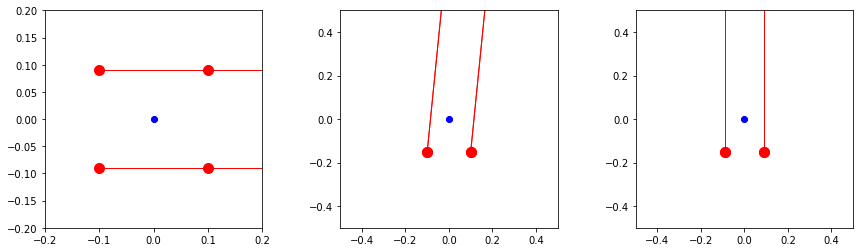

In [147]:
from quadprog import solve_qp
from mpl_toolkits import mplot3d
import matplotlib.patches as patches

# The Cd_comp and D_comp are good, dont touch!

computed_forces, f, xu, iters, lagr, iact = solve_qp(Q, -q[:,0], Cd_comp.T, D_comp[:,0])
computed_forces     = computed_forces[:, np.newaxis]

def getForces(xf, offset_horizon = 0):
    offset = offset_horizon*12
    
    
    f_fl = ((ROBOT_TOTAL_MASS/4)*np.array([0,0,9.8]) - xf[offset:offset+3,0]) * DELTAT 
    f_fr = ((ROBOT_TOTAL_MASS/4)*np.array([0,0,9.8]) - xf[3+offset:offset+6,0]) * DELTAT
    f_bl = ((ROBOT_TOTAL_MASS/4)*np.array([0,0,9.8]) - xf[6+offset:offset+9,0]) * DELTAT 
    f_br = ((ROBOT_TOTAL_MASS/4)*np.array([0,0,9.8]) - xf[9+offset:offset+12,0]) * DELTAT 
    
    f_fl = (xf[offset:offset+3,0]) 
    f_fr = (xf[3+offset:offset+6,0]) 
    f_bl = (xf[6+offset:offset+9,0]) 
    f_br = (xf[9+offset:offset+12,0]) 
    
    return f_fl,f_fr,f_bl,f_br

f_fl,f_fr,f_bl,f_br = getForces(computed_forces, offset_horizon = 0)




print(f_fl)
print(f_fr)
print(f_bl)
print(f_br)





def plotForce(axes, rel_foot_x, rel_foot_y, f_x, f_y):
    axes.plot([rel_foot_x, rel_foot_x + f_x], [rel_foot_y, rel_foot_y + f_y], color = 'red', linewidth = 1)
    axes.scatter(rel_foot_x, rel_foot_y, color = 'red', s = 100)
    axes.scatter(0, 0, color = 'blue', s = 30)


fig, axes = plt.subplots(1,3,figsize = (15,4))

plotForce(axes[0], rel_foot_fl[0], rel_foot_fl[1], f_fl[0], f_fl[1])
plotForce(axes[0], rel_foot_fr[0], rel_foot_fr[1], f_fr[0], f_fr[1])
plotForce(axes[0], rel_foot_bl[0], rel_foot_bl[1], f_bl[0], f_bl[1])
plotForce(axes[0], rel_foot_br[0], rel_foot_br[1], f_br[0], f_br[1])
axes[0].set_xlim([-0.2, 0.2])
axes[0].set_ylim([-0.2, 0.2])
axes[0].set_aspect('equal')

plotForce(axes[1], rel_foot_fl[0], rel_foot_fl[2], f_fl[0], f_fl[2])
plotForce(axes[1], rel_foot_fr[0], rel_foot_fr[2], f_fr[0], f_fr[2])
plotForce(axes[1], rel_foot_bl[0], rel_foot_bl[2], f_bl[0], f_bl[2])
plotForce(axes[1], rel_foot_br[0], rel_foot_br[2], f_br[0], f_br[2])
axes[1].set_xlim([-0.5, 0.5])
axes[1].set_ylim([-0.5, 0.5])
axes[1].set_aspect('equal')

plotForce(axes[2], rel_foot_fl[1], rel_foot_fl[2], f_fl[1], f_fl[2])
plotForce(axes[2], rel_foot_fr[1], rel_foot_fr[2], f_fr[1], f_fr[2])
plotForce(axes[2], rel_foot_bl[1], rel_foot_bl[2], f_bl[1], f_bl[2])
plotForce(axes[2], rel_foot_br[1], rel_foot_br[2], f_br[1], f_br[2])
axes[2].set_xlim([-0.5, 0.5])
axes[2].set_ylim([-0.5, 0.5])
axes[2].set_aspect('equal')


In [139]:
computed_forces[12:24]

array([[0.60643681],
       [0.        ],
       [6.06436812],
       [0.60643681],
       [0.        ],
       [6.06436812],
       [0.60643681],
       [0.        ],
       [6.06436812],
       [0.60643681],
       [0.        ],
       [6.06436812]])

[0. 0. 0.]

[0. 0. 0.]

[-6.94200253e-13  1.52970028e+00  3.43813866e-13]



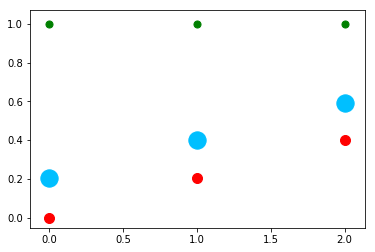

In [148]:
predicted_state = Aqp.dot( initial_state ) + Bqp.dot(computed_forces)
predicted_state = predicted_state[:,0]


x_init = np.hstack([estimated_base_ang, estimated_base_pos, estimated_base_ang_vel, estimated_base_vel, [0,0,-9.8]])

for k in range(HORIZON):
    ref_base_ang     = estimated_base_ang + k * DELTAT * des_base_ang_vel
    ref_base_pos     = estimated_base_pos + k * DELTAT * des_base_vel
    ref_base_ang_vel = des_base_ang_vel
    ref_base_vel     = des_base_vel
    
    
    
    pred_base_ang     = np.array([ predicted_state[DYN_STATE_DIM*k],    predicted_state[DYN_STATE_DIM*k + 1],  predicted_state[DYN_STATE_DIM*k + 2] ])
    pred_base_pos     = np.array([ predicted_state[DYN_STATE_DIM*k+3],  predicted_state[DYN_STATE_DIM*k + 4],  predicted_state[DYN_STATE_DIM*k + 5] ])
    pred_base_ang_vel = np.array([ predicted_state[DYN_STATE_DIM*k+6],  predicted_state[DYN_STATE_DIM*k + 7],  predicted_state[DYN_STATE_DIM*k + 8] ])
    pred_base_vel     = np.array([ predicted_state[DYN_STATE_DIM*k+9],  predicted_state[DYN_STATE_DIM*k + 10], predicted_state[DYN_STATE_DIM*k + 11] ])

    
    #####################################################
    pred_pos_fl = rel_foot_fl - k * DELTAT * des_base_vel
    pred_pos_fr = rel_foot_fr - k * DELTAT * des_base_vel
    pred_pos_bl = rel_foot_bl - k * DELTAT * des_base_vel
    pred_pos_br = rel_foot_br - k * DELTAT * des_base_vel
    
    stance_feet = [1,1,1,1]
    
    num_stance_feet = np.sum( stance_feet )
    
    yaw = ref_base_ang[2]
    Rz = getRz(yaw)
    
    InertiaTrans = Rz.dot(Inertia).dot(Rz.T)
    InertiaInv = np.linalg.inv(InertiaTrans)
    
    A = getAmatrix(yaw, InertiaInv, pred_pos_fl, pred_pos_fr, pred_pos_bl, pred_pos_br, stance_feet)
    B = getBmatrix(yaw, InertiaInv, pred_pos_fl, pred_pos_fr, pred_pos_bl, pred_pos_br)
    
    Adyn = np.eye(DYN_STATE_DIM) + A * DELTAT
    Bdyn = B * DELTAT
    
    

    forces_k = computed_forces[k*12:(k+1)*12]
    pred_k = Adyn.dot(x_init) + Bdyn.dot(forces_k)[:,0]
    

    pred_base_ang_k     = x_init[:3]
    pred_base_pos_k     = x_init[3:6]
    pred_base_ang_vel_k = x_init[6:9]
    pred_base_vel_k     = x_init[9:12]
    
    
    print(pred_base_ang_k)
    
    ####################################################    

    plt.scatter(k,pred_base_vel[0], color = 'deepskyblue', s =300)
    plt.scatter(k,pred_base_vel_k[0], color = 'red', s = 100)
    
    plt.scatter(k,ref_base_vel[0], color = 'green', s = 50)

    
    x_init = pred_k.copy()
    
    print("")

    
#plt.ylim([0,None])

[[-6.00659084e-13]
 [ 5.83015737e-13]
 [ 6.00659084e-12]
 [ 2.79391404e-14]
 [-6.92601280e-17]
 [-6.92601337e-16]
 [ 7.53581229e-13]
 [ 1.55640281e-16]
 [-1.55640423e-15]
 [-1.04496432e-12]
 [-1.04496432e-12]
 [ 1.04496432e-11]]
[[-6.00659084e-13]
 [ 5.83015737e-13]
 [ 6.00659084e-12]]
[[ 2.79391404e-14]
 [-6.92601280e-17]
 [-6.92601337e-16]]
[[ 7.53581229e-13]
 [ 1.55640281e-16]
 [-1.55640423e-15]]
[[-1.04496432e-12]
 [-1.04496432e-12]
 [ 1.04496432e-11]]


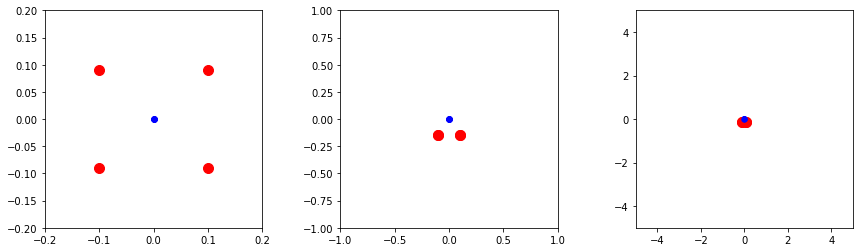

In [128]:
k = 3
forces_k = computed_forces[k*12:(k+1)*12]

f_fl,f_fr,f_bl,f_br = forces_k[:3], forces_k[3:6], forces_k[6:9], forces_k[9:12]


print(forces_k)

print(f_fl)
print(f_fr)
print(f_bl)
print(f_br)



fig, axes = plt.subplots(1,3,figsize = (15,4))

plotForce(axes[0], rel_foot_fl[0], rel_foot_fl[1], f_fl[0], f_fl[1])
plotForce(axes[0], rel_foot_fr[0], rel_foot_fr[1], f_fr[0], f_fr[1])
plotForce(axes[0], rel_foot_bl[0], rel_foot_bl[1], f_bl[0], f_bl[1])
plotForce(axes[0], rel_foot_br[0], rel_foot_br[1], f_br[0], f_br[1])
axes[0].set_xlim([-0.2, 0.2])
axes[0].set_ylim([-0.2, 0.2])
axes[0].set_aspect('equal')

plotForce(axes[1], rel_foot_fl[0], rel_foot_fl[2], f_fl[0], f_fl[2])
plotForce(axes[1], rel_foot_fr[0], rel_foot_fr[2], f_fr[0], f_fr[2])
plotForce(axes[1], rel_foot_bl[0], rel_foot_bl[2], f_bl[0], f_bl[2])
plotForce(axes[1], rel_foot_br[0], rel_foot_br[2], f_br[0], f_br[2])
axes[1].set_xlim([-1, 1])
axes[1].set_ylim([-1, 1])
axes[1].set_aspect('equal')

plotForce(axes[2], rel_foot_fl[1], rel_foot_fl[2], f_fl[1], f_fl[2])
plotForce(axes[2], rel_foot_fr[1], rel_foot_fr[2], f_fr[1], f_fr[2])
plotForce(axes[2], rel_foot_bl[1], rel_foot_bl[2], f_bl[1], f_bl[2])
plotForce(axes[2], rel_foot_br[1], rel_foot_br[2], f_br[1], f_br[2])
axes[2].set_xlim([-5, 5])
axes[2].set_ylim([-5, 5])
axes[2].set_aspect('equal')


In [ ]:
f_fl,f_fr,f_bl,f_br = getForces(forces_k, offset_horizon = 0)
print(f_fl[:,0])
print(f_fr[:,0])
print(f_bl[:,0])
print(f_br[:,0])


fl_cross = B[6:9, :3]
fr_cross = B[6:9, 3:6]
bl_cross = B[6:9, 6:9]
br_cross = B[6:9, 9:12]

print(fl_cross.dot(f_fl))
print("")
print(fr_cross.dot(f_fr))
print("")
print(bl_cross.dot(f_bl))
print("")
print(br_cross.dot(f_br))

B_vel = B[6:9,:]
B_vel.dot(forces_k)


In [ ]:
np.linalg.norm(f_fl)

In [ ]:


xf, f, xu, iters, lagr, iact = solve_qp(Q, q, None, None, meq=0)



In [ ]:
A0 = np.hstack([O3,  O3,  O3,  O3,  O3])


np.vstack([A0,A0])